In [1]:
# Written by Christopher Straub
# inspired from Francois Fleuret <francois@fleuret.org> code (practical3)

import math
from torch import empty
from torch import set_grad_enabled
import numpy as np
import dlc_practical_prologue as prologue
set_grad_enabled(False)


In [2]:
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
    def backward(self, *gradwrtoutput): 
        raise NotImplementedError
    def param(self): 
        return []

In [3]:
class Linear(Module):
    """
    Implement the fully connected layer module
    """
    def __init__(self,input_size, hidden_size):
        super().__init__()
        epsilon = 1e-6
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # Initialisation with Xavier methods
        self.weights=empty(input_size, hidden_size).uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size))#Weight
        self.biais=empty(hidden_size).uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size)) #bias

    def sigma(self,x):
        out = 0
        if len(x.size())>1: #Processing for mini-batch
            
            one_matrix = empty(x.size(0),self.hidden_size).zero_().add(1)#we multiply the result with the batch size
            out = x.mm(self.weights)+self.biais.view(1,-1)*one_matrix #Could be optimize with broadcasting
                        
        else : #single input
            #W*x + b
            out = self.weights.t().mv(x)+self.biais
            
        return out 
    
    def dsigma(self,x):
        out = 0
        if len(x.size())>1:
            out = x.mm(self.weights.T) #matrix output (X (M_batch x N_input_size) * W (N input_size x hidden_size) = out (M_batch x hidden_size))
        else: 
            out = self.weights().mv(x) #vector output           
        return out
    
    def param(self):
        return [self.weights,self.biais]
    
    def set_param(self,new_w,new_b):
        """
        Allow to update the parameters when we have done the optimize step calculation.
        """
        self.weights= new_w
        self.biais = new_b
        

### Activation Functions

In [4]:
class Tanh(Module):
    """
    Implement activation layer tanh
    """
    def __init__(self):
        super().__init__()
    def sigma(self,x):
        return x.tanh()
    def dsigma(self,x):
        return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)

In [5]:
class Relu( Module ) :
    def __init__(self):
        super().__init__()
    def sigma(self,x):
        return x.max(empty(x.size()).zero_())
    def dsigma(self,x):
        out = empty(x.size()).zero_()
        out[x>0]=1
        return out
   

### Loss functions

In [6]:
class MSE(Module):
    """
    Implement the loss function Mean Square Error
    """
    def __init__(self):
        super().__init__()
        
    def sigma(self,x,y):        
        return (x - y).pow(2).sum()
    
    def dsigma(self,x,y):
        #if len(y.size())>1:
        #    y = y.argmax(0)
            
        return 2*(x - y)
    

In [7]:
class CrossEntropy(Module):
    """
    Implement the cross entropy loss function
    """
    def __init__(self):
        super().__init__()
    def sigma(self,x,y):
        y_=y.argmax().item()
        return -(x[y_].exp().div(x.exp().sum()).log())
    def dsigma(self,x,y):
        y_=y.argmax().item()
        out= x.exp().div(x.exp().sum())
        out[y_]=1-x[y_].exp().div(x.exp().sum())
        return out 
   

### Optimizer

In [8]:
class SGD(Module):
    def __init__(self,net,lr):
        super().__init__()
        self.net = net
        self.lr = lr
    def sigma(self,param,grad):
        out=[]
        for i in range(len(param)):
            out.append(param[i] - self.lr * grad[i].sum(0) ) #en faisant que n(t,b) sot séquentielle
        return out
    def step(self):
        for i in range(len(net.param())):
            new_w,new_b=self.sigma(self.net.get_param(i),self.net.get_grad(i))
            net.set_param(i,new_w,new_b)




### Core module

In [9]:
class Loss(Module):
    """
    Loss has a network and a loss. 
    It uses the "sigma" method of the loss function (MSE)
    """
    def __init__(self,loss,net):
        super().__init__()
        self.net = net
        self.loss = loss
        self.acc_loss=0
        self.nb_train_errors=0
        
    def sigma(self,x,y):
        return self.loss.sigma(x,y)
    
    def dsigma(self,x,y):
        return self.dloss.sigma(x,y)
    
    def assign(self, net):
        self.net = net 
    
    def predict(self,x,test_target):
        """"
        just to evaluate the prediction of the network on one mini-batch
        """
        
        
        return (test_target.argmax(1)!=x.argmax(1)).sum(),self.loss.sigma(x, test_target).sum()
    def backward(self,*gradwrtoutput):
        #This function call the forward method of the network for one mini-batch, and then the backward function of the network
        x,s = self.net.forward(self.net.train)
        
        #x has row of mini_batch size and column of linear output (before activation))
        #s has row of mini_batch size and column of activation function (after activation))   
    
        nb_train_errors,acc_loss=self.predict(x[-1],self.net.train_target)
        self.nb_train_errors+=nb_train_errors
        self.acc_loss+=acc_loss
        dl_dx2 = self.loss.dsigma(x[-1], self.net.train_target)
        gradwrtoutput = [[x,s],dl_dx2]
        self.net.backward(*gradwrtoutput)

In [10]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.Parameters = [] #List of fully connected layers
        self.Activation = [] #List of activation functions
        self.dl_dw = []
        self.dl_db = []
        self.train = []
        self.train_target = []
        self.forward_value=[]
        self.num_sample = 0
        self.num_parameters = 0
    def forward(self,*input):
        train_input=input[0]
        x = train_input
        out_s = []
        out_x = [train_input]
        for i in range(len(self.Activation)):
            s = self.Parameters[i].sigma(x)
            out_s.append(s)
            x = self.Activation[i].sigma(s)
            out_x.append(x)
        return [out_x,out_s]

    def backward(self,*gradwrtoutput):
        """
        call by the Loss module for updating the weigths of the network
        """
        layer_output,dl_dx2 = gradwrtoutput
        dl_dw = self.dl_dw
        dl_db = self.dl_db
        N=len(dl_dw)
        x,s=layer_output
        dl_ds2 = self.Activation[N-1].dsigma(s[N-1]) * dl_dx2
        dl_dw2 = dl_dw[N-1] #N matrix of size of input_size x hidden_size 
        dl_db2 = dl_db[N-1] #N matrix of size of hidden_size x 1
        
        #print('dl_dw2',dl_dw2.size())
        
        #Like TP3 but multidimensional
        # Updating accumulator of the last weigths
        dl_dw2.add_( x[N-1].view(x[N-1].size(0),x[N-1].size(1),1).matmul(dl_ds2.view(dl_ds2.size(0),1,dl_ds2.size(1))))
        
        # Updating accumulator of the last bias
        dl_db2.add_(dl_ds2)
        
        
        out_dl_dw = [dl_dw2]
        out_dl_db = [dl_db2]

        for i in range(1,N,1): #Backpropagate for each layer once we took care of the loss

            dl_dx1 = self.Parameters[N-i].dsigma(dl_ds2) #c'est pas très jolie mais par Parameters je veux dire la fonction devrivant les poids de la couche cache (ici linear)
            dl_ds1 = self.Activation[N-1-i].dsigma(s[N-1-i]) * dl_dx1
            dl_dw1 = dl_dw[N-1-i]
            dl_db1 = dl_db[N-1-i]
             
            #updating accumulator of the current weigths   
            dl_dw1.add_(x[N-1-i].view(x[N-1-i].size(0),x[N-1-i].size(1),1).matmul(dl_ds1.view(dl_ds1.size(0),1,dl_ds1.size(1))))
            #updating accumulator of the current bias
            dl_db1.add_(dl_ds1)
            
            out_dl_dw.insert(0,dl_dw1)
            out_dl_db.insert(0,dl_db1)
            dl_ds2 = dl_ds1
            
        self.dl_dw,self.dl_db = out_dl_dw,out_dl_db
        
        
    def param(self):
        return self.Parameters
    
    def init(self,new_Parameters,new_Activation):
        self.num_parameters= len(new_Parameters)
        self.Parameters= new_Parameters
        self.Activation = new_Activation

    def set_param(self,num_layer,new_w,new_b):
        self.Parameters[num_layer].set_param(new_w,new_b)
        
    def get_grad(self,num_layer):
        return [self.dl_dw[num_layer],self.dl_db[num_layer]]
    
    def zero_grad(self):
        for dw in self.dl_dw:
            dw.zero_()
        for db in self.dl_db:
            db.zero_()
    def get_param(self,num_layer):
        return self.Parameters[num_layer].param()
    
    def assign(self, train,train_target):
        
        if len(train_input.size())>1: #mini batch
            self.train = train
            self.train_target = train_target
            if self.num_sample != train.size(0):
                self.num_sample = train.size(0)
                self.dl_dw = [empty(self.num_sample,p.param()[0].size(0),p.param()[0].size(1)).zero_() for p in self.Parameters]
                self.dl_db = [empty(self.num_sample,p.param()[1].size(0)).zero_() for p in self.Parameters]
        else : 
            self.num_sample = 1
            self.train = train
            self.train_target = train_target
            self.dl_dw = [empty(p.param()[0].size()) for p in self.Parameters]
            self.dl_db = [empty(p.param()[1].size()) for p in self.Parameters]


In [11]:
class Sequential(Module):
    def __init__(self,*layers):
        super().__init__()
        self.layers = layers 
    def init_net(self):
        net = Net()
        new_Parameters=[]
        new_Activation=[]
        i = 0
        for layer in self.layers : 
            if np.mod(i,2)==0:
                new_Parameters.append(layer)
            else : 
                new_Activation.append(layer)
            i=i+1
        net.init(new_Parameters,new_Activation)
        return net 

In [12]:
def one_hot(a):
    num_class = a.max()+1
    N=a.size(0)
    out = empty(N,num_class).zero_()
    for i in range(N):
        out[i][a[i]]=1 
    return out 
        

### Test Script

In [13]:

def generate_disc_set(nb):
    input = empty(nb, 2).uniform_(-1, 1)
    target = input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long()
    
    return input, one_hot(target)

In [14]:
from time import time


nb_train_samples=1000
nb_test_samples=1000
nb_epochs = 1000
nb_hidden = 25
eta = 1e-1 / nb_train_samples
epsilon = 1e-6


train_input, train_target = generate_disc_set(nb_train_samples)
test_input, test_target = generate_disc_set(nb_test_samples)

mean, std = train_input.mean(), train_input.std()

train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)


nb_classes = train_target.size(1)




net = Sequential(Linear (train_input.size(1),(nb_hidden)),Tanh(),
                 Linear( nb_hidden,nb_hidden),Tanh(),
                 Linear( nb_hidden,nb_hidden),Tanh(),
                 Linear( nb_hidden,nb_hidden),Tanh(),
                 Linear( nb_hidden,nb_classes),Tanh()).init_net()

loss = Loss(MSE(),net)
optimizer= SGD(net,eta)

nb_epochs = 1000
mini_batch_size = 500
zeit = empty(nb_epochs,1000).zero_()
for e in range(nb_epochs):
    
    i=0
    if e==400:
        mini_batch_size=250
    if e ==500:
        mini_batch_size=500
        
    for b in range(0, train_input.size(0), mini_batch_size):

    # Back-prop

        net.assign(train_input.narrow(0, b, mini_batch_size),train_target.narrow(0, b, mini_batch_size))
        
        tic = time()
        loss.backward()#This function call the forward method of the network then the backward for calculating the accumulators
        toc = time()
        zeit[e][i]=(toc-tic)
        i+=1
        # Gradient step with SGD
        optimizer.step()
    
    net.zero_grad()
    # Test error

    nb_test_errors = 0
    
    
    x,s = net.forward(test_input)
    x2 = x[-1]
    
    nb_test_errors,_=loss.predict(x2,test_target)
       

    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(e,
                  loss.acc_loss.log(),
                  (100 * loss.nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))
    loss.nb_train_errors  = 0
    loss.acc_loss=0

0 acc_train_loss 6.85 acc_train_error 58.90% test_error 56.90%
1 acc_train_loss 6.30 acc_train_error 59.00% test_error 54.40%
2 acc_train_loss 6.23 acc_train_error 56.70% test_error 52.20%
3 acc_train_loss 6.22 acc_train_error 56.40% test_error 51.10%
4 acc_train_loss 6.22 acc_train_error 57.00% test_error 50.50%
5 acc_train_loss 6.22 acc_train_error 57.00% test_error 49.90%
6 acc_train_loss 6.22 acc_train_error 56.10% test_error 49.60%
7 acc_train_loss 6.21 acc_train_error 55.30% test_error 49.40%
8 acc_train_loss 6.21 acc_train_error 54.90% test_error 49.10%
9 acc_train_loss 6.21 acc_train_error 54.20% test_error 48.80%
10 acc_train_loss 6.21 acc_train_error 53.90% test_error 48.80%
11 acc_train_loss 6.21 acc_train_error 53.50% test_error 48.80%
12 acc_train_loss 6.21 acc_train_error 53.20% test_error 48.70%
13 acc_train_loss 6.21 acc_train_error 52.50% test_error 48.40%
14 acc_train_loss 6.21 acc_train_error 51.80% test_error 49.20%
15 acc_train_loss 6.21 acc_train_error 51.00% test

In [15]:
from torch import save
from torch import load
save(net,'./project_net_2')
from torch import cat
import matplotlib.pyplot as plt

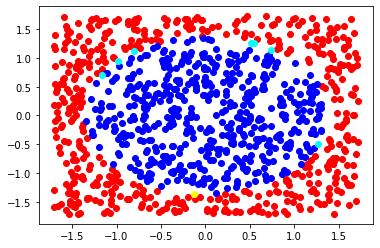

In [16]:
x,s = net.forward(test_input)
x=x[-1]
pred_class0 = (x.argmax(1)-1).nonzero()        
pred_class1 = x.argmax(1).nonzero()
class0 =(test_target.argmax(1)-1).nonzero()
class1 =(test_target.argmax(1)).nonzero()
combined = cat((pred_class0, class0))
uniques, counts = combined.unique(return_counts=True)
miss_classify0 = uniques[counts == 1]
well_classify0 = uniques[counts > 1]
combined = cat((pred_class1, class1))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts == 1]
well_classify1 = uniques[counts > 1]

combined = cat((miss_classify0.view(-1), class0.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify0 = uniques[counts > 1]

combined = cat((miss_classify1.view(-1), class1.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts > 1]
plt.scatter(test_input[well_classify1].t()[0],test_input[well_classify1].t()[1],c='red')
plt.scatter(test_input[well_classify0].t()[0],test_input[well_classify0].t()[1],c='blue')
plt.scatter(test_input[miss_classify0].t()[0],test_input[miss_classify0].t()[1],c='cyan')
plt.scatter(test_input[miss_classify1].t()[0],test_input[miss_classify1].t()[1],c='yellow')



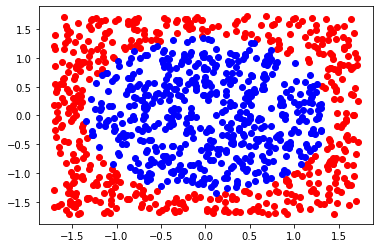

In [17]:
x,s = net.forward(test_input)
x=x[-1]
pred_class0 = (x.argmax(1)-1).nonzero()        
pred_class1 = x.argmax(1).nonzero()
class0 =(test_target.argmax(1)-1).nonzero().view(-1)
class1 =(test_target.argmax(1)).nonzero().view(-1)


combined = cat((miss_classify1.view(-1), class1.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts > 1]
plt.scatter(test_input[class1].t()[0],test_input[class1].t()[1],c='red')
plt.scatter(test_input[class0].t()[0],test_input[class0].t()[1],c='blue')




In [18]:
#b = load('./project_net_2')

In [19]:
print('moyenne des temps par backward : ',zeit.mean())
print('temps d entrainement totale : ', zeit.sum())

moyenne des temps par backward :  tensor(1.7567e-05)
temps d entrainement totale :  tensor(17.5671)
